In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import spacy

In [2]:
df=pd.read_csv("newcorp.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   article_id          266 non-null    int64 
 1   title               266 non-null    object
 2   article_text        266 non-null    object
 3   summary_1_text      266 non-null    object
 4   summary_2_text      266 non-null    object
 5   summary_3_text      266 non-null    object
 6   summary_4_text      266 non-null    object
 7   summary_5_text      266 non-null    object
 8   thesis_1_text       266 non-null    object
 9   thesis_2_text       266 non-null    object
 10  thesis_3_text       266 non-null    object
 11  thesis_4_text       266 non-null    object
 12  thesis_5_text       266 non-null    object
 13  lead                266 non-null    object
 14  body                266 non-null    object
 15  conclusion          266 non-null    object
 16  article_segments    266 no

In [4]:
text_list=[]
label_list=[]

In [5]:
def datasetmaker(x):
    x=json.loads(x)
    for i in range(0,len(x["paragraphs"])):
        for j in range(0,len(x["paragraphs"][i])):
            text_list.append(x["paragraphs"][i][j]["text"])
            label_list.append(x["paragraphs"][i][j]["label"])

In [6]:
df["article_segments"].apply(lambda x:datasetmaker(x))

0      None
1      None
2      None
3      None
4      None
       ... 
261    None
262    None
263    None
264    None
265    None
Name: article_segments, Length: 266, dtype: object

In [7]:
len(text_list)

28772

In [8]:
len(label_list)

28772

In [9]:
df_main={"text":text_list,"label":label_list}

In [10]:
df_main=pd.DataFrame(df_main)

In [11]:
df_main.head()

,text,label
0,"2015: Beyond Obama, new Congress, we need a re...",title
1,"In the film, ""Girl Interrupted,"" Winona Ryder ...",anecdote
2,.,no-unit
3,The year is 1967,anecdote
4,and,no-unit


In [12]:
len(text_list)

28772

In [13]:
df_main["label"].value_counts()

no-unit          15193
assumption        9049
anecdote          2430
testimony         1064
statistics         381
title              266
common-ground      232
other              157
Name: label, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'title'),
  Text(1, 0, 'anecdote'),
  Text(2, 0, 'no-unit'),
  Text(3, 0, 'statistics'),
  Text(4, 0, 'assumption'),
  Text(5, 0, 'testimony'),
  Text(6, 0, 'common-ground'),
  Text(7, 0, 'other')])

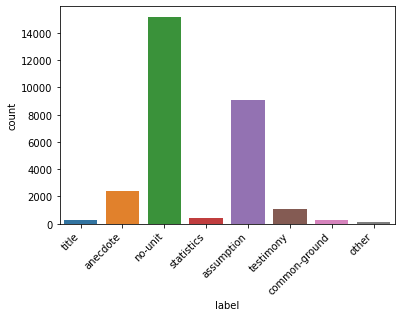

In [14]:
sns.countplot(data=df_main,x="label")
plt.xticks(rotation=45, ha='right')

In [15]:
df_main[df_main["label"]=="no-unit"]["text"]

2                    .
4                  and
6                    .
8                    .
10       As 2014 ends,
             ...      
28763                -
28765                .
28767                .
28769                .
28771                .
Name: text, Length: 15193, dtype: object

In [16]:
len_no_unit=df_main[df_main["label"]=="no-unit"]["text"].apply(lambda x:len(x.split(" ")))

In [17]:
len_no_unit.value_counts().head()

1    14530
2      327
3       94
4       63
6       28
Name: text, dtype: int64

#### Feel that a lot of no unit labels consist of just a single punctuation
#### Discarding these should be considered 
#### Makes the dataset very imbalanced 

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_main["label"]=le.fit_transform(df_main["label"])

In [19]:
X=df_main["text"]
y=df_main["label"]

In [38]:
y.head()

0    7
1    0
2    3
3    0
4    3
Name: label, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42,stratify=y)

In [21]:
Train=pd.concat([X_train,y_train],axis=1)

In [22]:
Test=pd.concat([X_test,y_test],axis=1)

In [23]:
Train.to_csv("train.csv",index=False)
Test.to_csv("test.csv",index=False)

In [24]:
from datasets import load_dataset

In [25]:
dataset = load_dataset('csv', data_files={'train': ['train.csv'],'test': 'test.csv'})

Using custom data configuration default-238cdf14e6a0b2b5


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/sai/.cache/huggingface/datasets/csv/default-238cdf14e6a0b2b5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [27]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23017
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5755
    })
})

In [28]:
def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length',truncation=True)

In [29]:
tokenized_datasets = dataset.map(tokenize_data, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [30]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [31]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 23017
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5755
    })
})

In [32]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=8)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [33]:
from transformers import TrainingArguments,Trainer

training_args = TrainingArguments("test_trainer", num_train_epochs=3)

In [34]:

from datasets import load_metric

metric = load_metric("accuracy")

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()